In [1]:
from collections import OrderedDict 
import numpy as np 
import torch 
from torch import optim 
import torch.nn as nn 
import torchvision 
from torchvision import transforms,models 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score

This script fine-tunes a pre-trained DenseNet121 model for binary classification of cat and dog images. It accomplishes this by freezing the pre-trained layers and replacing the original classifier with a new one tailored for binary classification. After training for just 10 epochs, the model achieves an accuracy score of 98.44%.


In [5]:
##Data preparation, taking from: https://www.microsoft.com/en-us/download/details.aspx?id=54765
import os
import shutil
from sklearn.model_selection import train_test_split

def split_images(input_folder, output_folder, test_size=0.2, random_state=42):
    
    os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)

    # Get all image files
    all_files = [os.path.join(root, file) for root, _, files in os.walk(input_folder) 
                 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split files into training and testing
    train_files, test_files = train_test_split(all_files, test_size=test_size, random_state=random_state)

    # Move files to respective directories
    for file, folder in zip(train_files + test_files, 
                            ['train'] * len(train_files) + ['test'] * len(test_files)):
        shutil.copy(file, os.path.join(output_folder, folder))

    print(f"Data split into {len(train_files)} training and {len(test_files)} testing images.")


main_path = "PetImages"
catimput_dir = main_path+"/Cat"
dogimput_dir = main_path+"/Dog"
catoutput_dir = main_path+"/cat"
dogoutput_dir = main_path+"/dog"
split_images(dogimput_dir,dogoutput_dir)

Data split into 10000 training and 2500 testing images.


In [23]:
train_dir = main_path+'/train' 
test_dir =  main_path+'/test'

transform = transforms.Compose([transforms.Resize(255), 
    transforms.CenterCrop(224), 
    transforms.ToTensor()]) 
  
dataset = torchvision.datasets.ImageFolder(train_dir, transform= transform) 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128,shuffle=True) 

dataset = torchvision.datasets.ImageFolder(test_dir, transform= transform) 
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128,shuffle=True) 

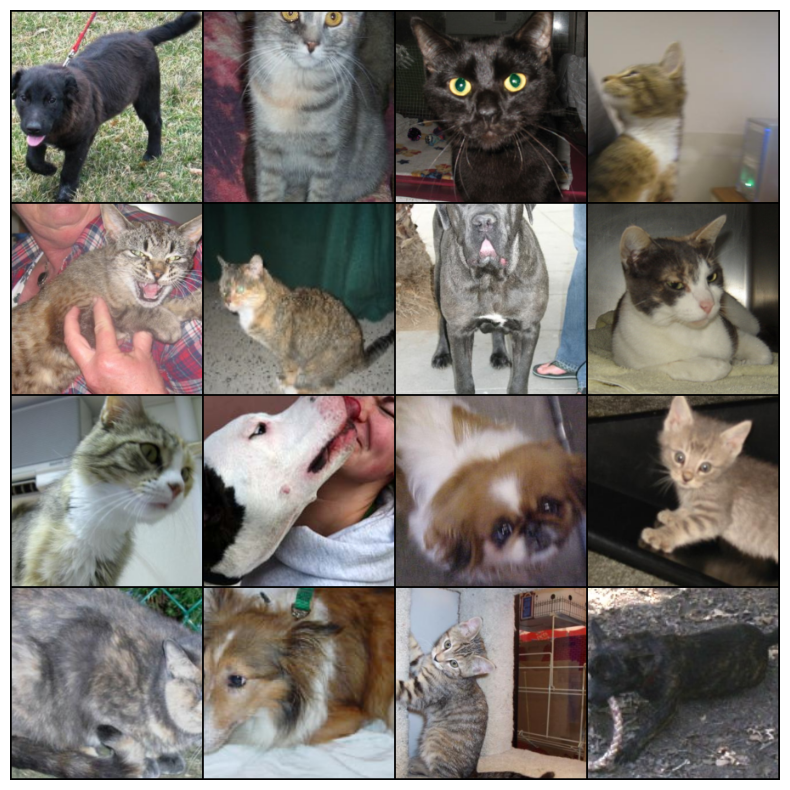

In [37]:
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(image_torch)
    
 
X_train, y_train = next(iter(train_loader)) 
 
# Make a grid from batch 
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4) 
 
imshow(image_grid) 

In [ ]:
# download pre-trained network
model = models.densenet121(pretrained = True) 
model 

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
# modify layers
# freeze all layers
for params in model.parameters(): 
    params.requires_grad = False 


In [27]:
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [28]:

#overwrite classifier of model
model.classifier = nn.Sequential(OrderedDict([ 
    ('fc1',nn.Linear(1024,1)), 
    ('Output',nn.Sigmoid()) 
])) 
model


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [29]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model.to(device)

# Define optimizer and loss function
opt = optim.Adam(model.classifier.parameters())
loss_function = nn.BCELoss()
train_losses = []

model.train()
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for bat, (img, label) in enumerate(train_loader):
        
        # Move images and labels to GPU
        img, label = img.to(device), label.to(device)

        # Zero the gradients
        opt.zero_grad()

        # Forward pass
        output = model(img)

        # Calculate losses
        loss = loss_function(output.squeeze(), label.float())

        # Propagate losses
        loss.backward()

        # Update weights
        opt.step()

        # Update current train loss
        train_loss += loss.item()

    train_losses.append(train_loss)
    print(f"epoch: {epoch}, train_loss: {train_loss}")

 


epoch: 0, train_loss: 27.64825065433979
epoch: 1, train_loss: 10.88742376677692
epoch: 2, train_loss: 9.003592660650611
epoch: 3, train_loss: 7.947646631859243
epoch: 4, train_loss: 7.224623344838619
epoch: 5, train_loss: 7.269456242211163
epoch: 6, train_loss: 6.763457185588777
epoch: 7, train_loss: 6.382239546626806
epoch: 8, train_loss: 6.465076782274991
epoch: 9, train_loss: 5.9859195672906935


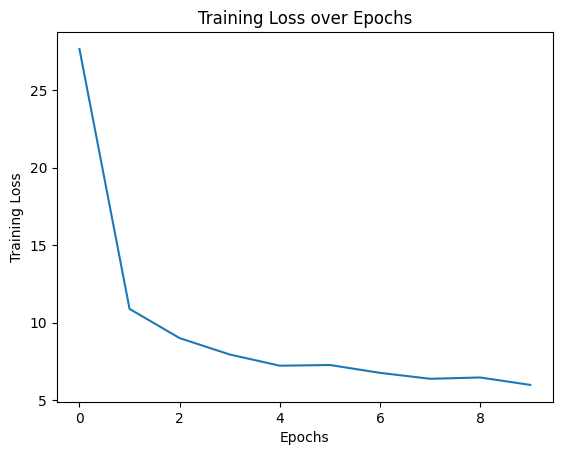

/tmp/ipykernel_15235/3121677903.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_labels[int(y_pred[num])])


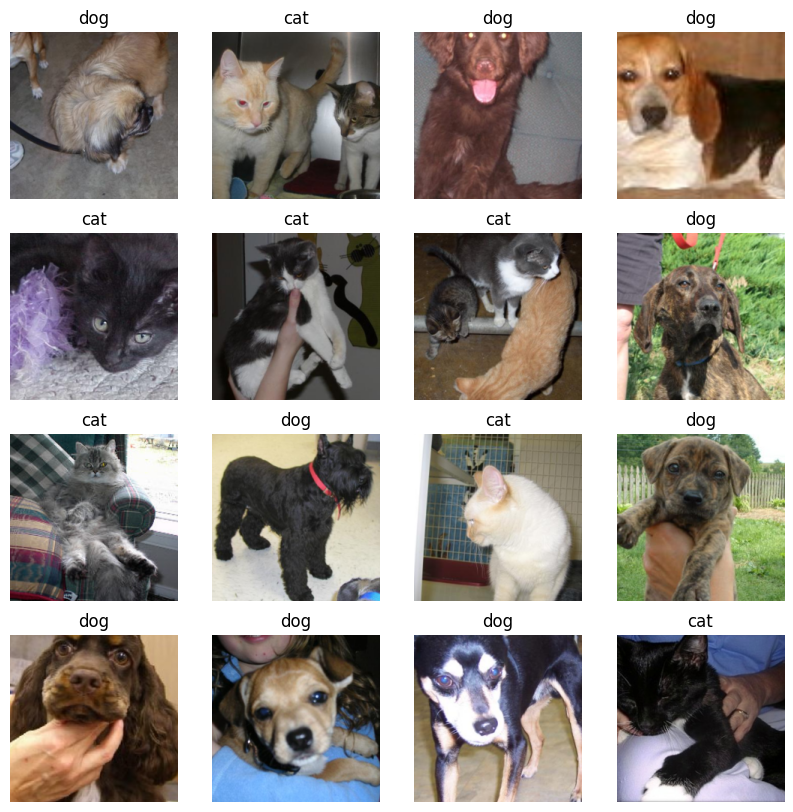

Accuracy Score: 98.44 %


In [39]:

#  Show losses over epoch
sns.lineplot(x=range(len(train_losses)), y=train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

#  Display sample images with predictions
fig = plt.figure(figsize=(10, 10))
class_labels = {0: 'cat', 1: 'dog'}

# Get a batch of test data
X_test, y_test = next(iter(test_loader))

# Move test data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)

with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.round()
    y_pred = y_pred.cpu().numpy()  # Move predictions back to CPU for visualization

# Create subplots
num_images = min(len(X_test), 16)  # Ensure we don't try to plot more than 24 images

for num, sample in enumerate(X_test[:num_images]):
    plt.subplot(4, 4, num + 1)
    plt.title(class_labels[int(y_pred[num])])
    plt.axis('off')
    sample = sample.cpu().numpy()  # Move sample back to CPU for visualization
    plt.imshow(np.transpose(sample, (1, 2, 0)))

plt.show()

#  Calculate accuracy
y_test = y_test.cpu().numpy()  # Move true labels back to CPU for accuracy calculation
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {np.round(acc * 100, 2)} %")
